In [ ]:
import requests
import pandas as pd
import yfinance as yf
pd.set_option('display.max_rows', None)


url = "https://en.wikipedia.org/wiki/List_of_S%26P_600_companies" 


def read_html_from_website(url):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        
        # Check if request was successful
        if response.status_code == 200:
            # Extract HTML content from the response
            html_content = response.text
            return html_content
        else:
            print("Failed to retrieve HTML. Status code:", response.status_code)
            return None
    except Exception as e:
        print("An error occurred:", e)
        return None

# # # Create 

html_content = read_html_from_website(url)
list_df = pd.read_html(html_content)
df = list_df[0]
df = df.drop(columns=["SEC filings","CIK"])
df = df.dropna()
#df = df.head(20)
df


In [ ]:
# Iterate through each row using iterrows()
for index, row in df.iterrows():
    ticker = row['Symbol']  # Extract ticker from the current row

    # Get financial data using yfinance
    ticker_obj = yf.Ticker(ticker)

    try:
        # Get desired financial information
        total_assets = ticker_obj.balance_sheet.T['Total Assets'].iloc[0]
        total_debt = ticker_obj.balance_sheet.T['Total Debt'].iloc[0]
        total_revenue = ticker_obj.income_stmt.T['Total Revenue'].iloc[0]
        net_income = ticker_obj.income_stmt.T['Net Income'].iloc[0]
        current_liabilities = ticker_obj.balance_sheet.T['Current Liabilities'].iloc[0]
        current_assets = ticker_obj.balance_sheet.T['Current Assets'].iloc[0]
        inventory = ticker_obj.balance_sheet.T['Inventory'].iloc[0]

        # Check for incomplete data
        if any(pd.isnull(value) for value in [
            total_assets,
            total_debt, 
            total_revenue, 
            net_income, 
            current_liabilities, 
            current_assets, 
            inventory
        ]):
            print(f"{ticker} removed from df: Incomplete data")
            df = df[df['Symbol'] != ticker]  # Remove ticker from DataFrame
            continue  # Skip to the next iteration if data is incomplete

        # Calculate derived metrics
        debt_ratio = total_debt / total_assets
        calculated_profit_margin = net_income / total_revenue
        asset_turnover_ratio = total_revenue / total_assets
        liquidity_ratio = current_assets / current_liabilities
        quick_ratio = (current_assets - inventory) / current_liabilities
        new_ratio = calculated_profit_margin * asset_turnover_ratio * liquidity_ratio / (debt_ratio * quick_ratio)
        # Add calculated metrics to DataFrame
        df.loc[index, 'Total Assets'] = total_assets
        df.loc[index, 'Total Debt'] = total_debt
        df.loc[index, 'Debt Ratio'] = debt_ratio
        df.loc[index, 'Total Revenue'] = total_revenue
        df.loc[index, 'Net Income'] = net_income
        df.loc[index, 'Inventory'] = inventory
        df.loc[index, 'Calculated Profit Margin'] = calculated_profit_margin
        df.loc[index, 'Asset Turnover Ratio'] = asset_turnover_ratio
        df.loc[index, 'Current Liabilities'] = current_liabilities
        df.loc[index, 'Current Assets'] = current_assets
        df.loc[index, 'Liquidity Ratio'] = liquidity_ratio
        df.loc[index, 'Quick Ratio'] = quick_ratio
        df.loc[index, 'New Ratio'] = new_ratio


    except KeyError:
        print(f"Error: Missing data for ticker {ticker}")
        
        df = df[df['Symbol'] != ticker] 

# Print or save the updated DataFrame
df

# df.to_csv("updated_financial_data.csv", index=False)  
# Example to save as CSV


In [ ]:
#import yfinance as yf
#ticker_object = yf.Ticker('AAON')
#balancesheet = ticker_object.balance_sheet
#print(balancesheet)

In [6]:
#pd.set_option('display.max_rows', None)

C:\Users\tom77\AppData\Local\Temp\ipykernel_34780\2344064776.py:55: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(sector_avg_turnover, linefmt='b-', markerfmt='bo', basefmt='k-', use_line_collection=True)  # Using stem plot


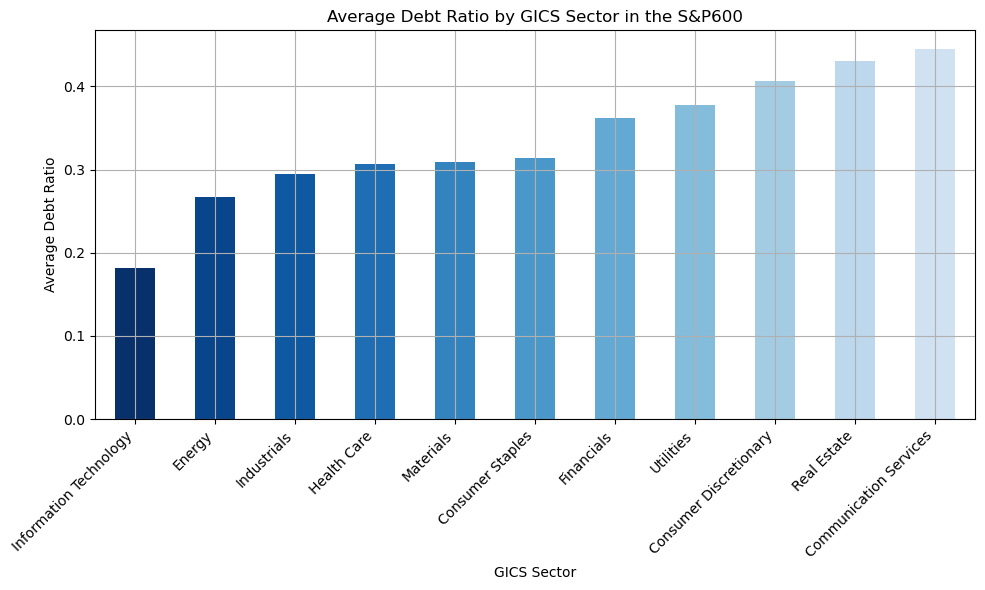

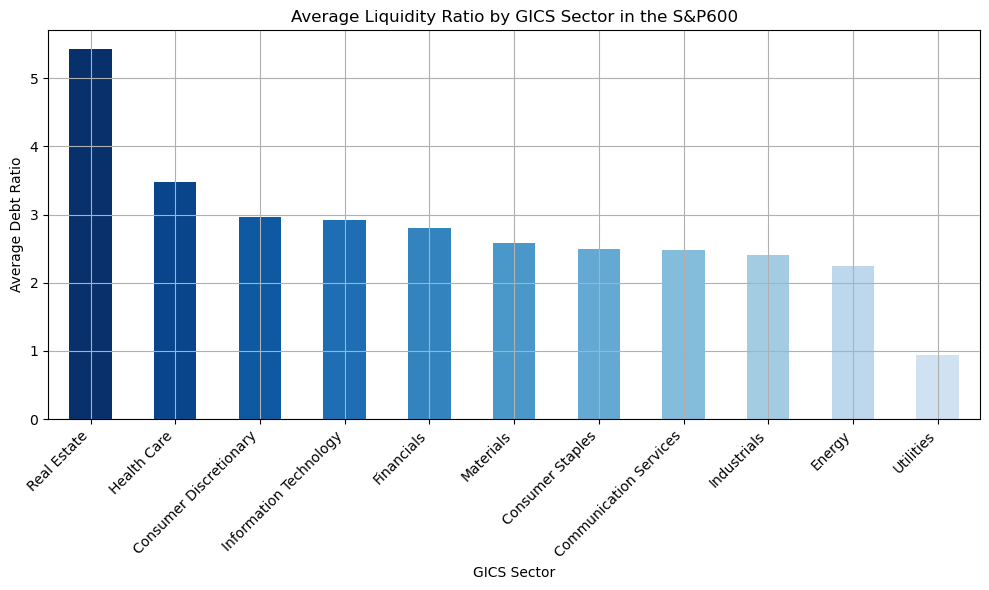

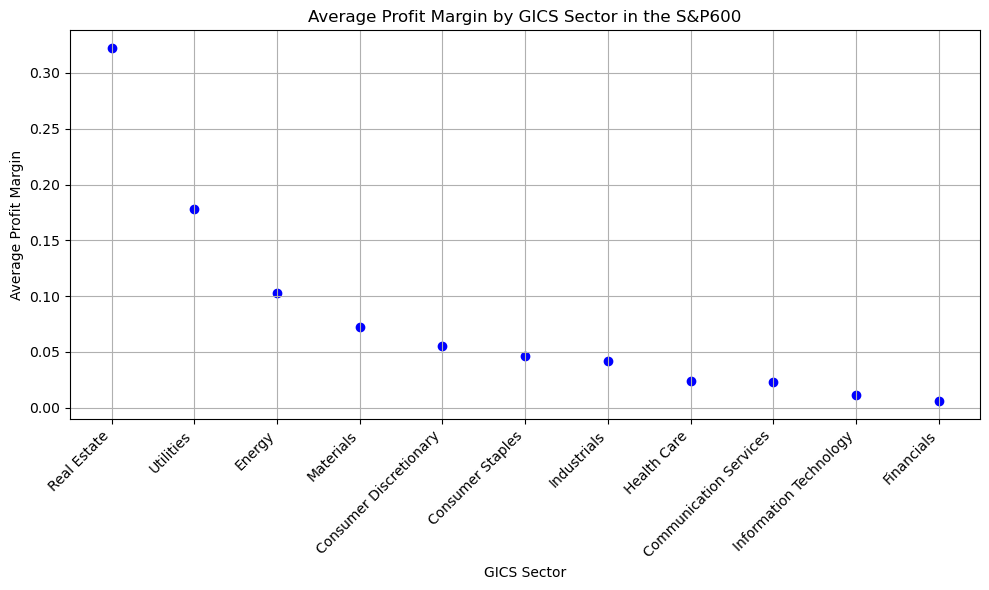

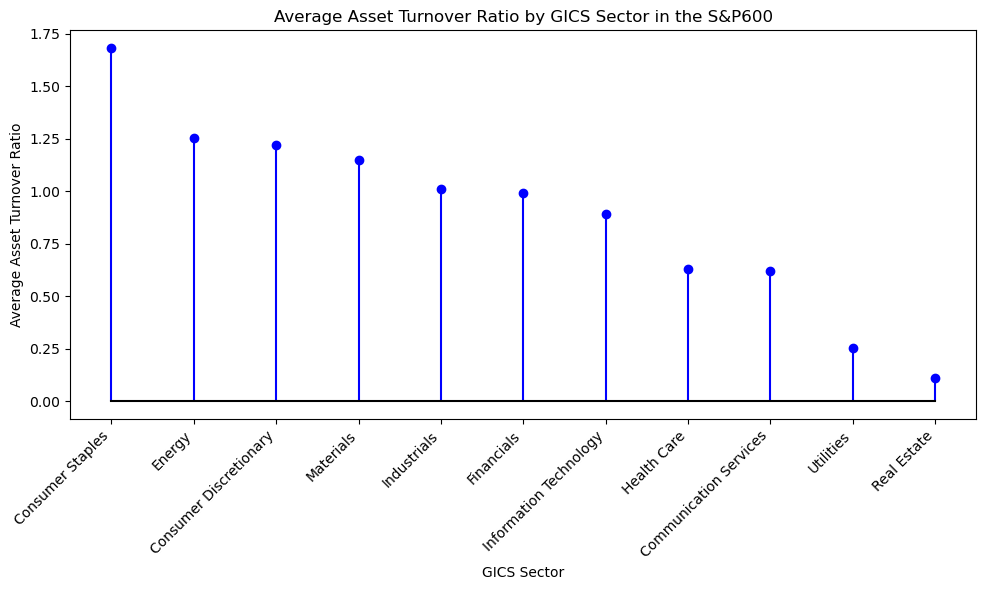

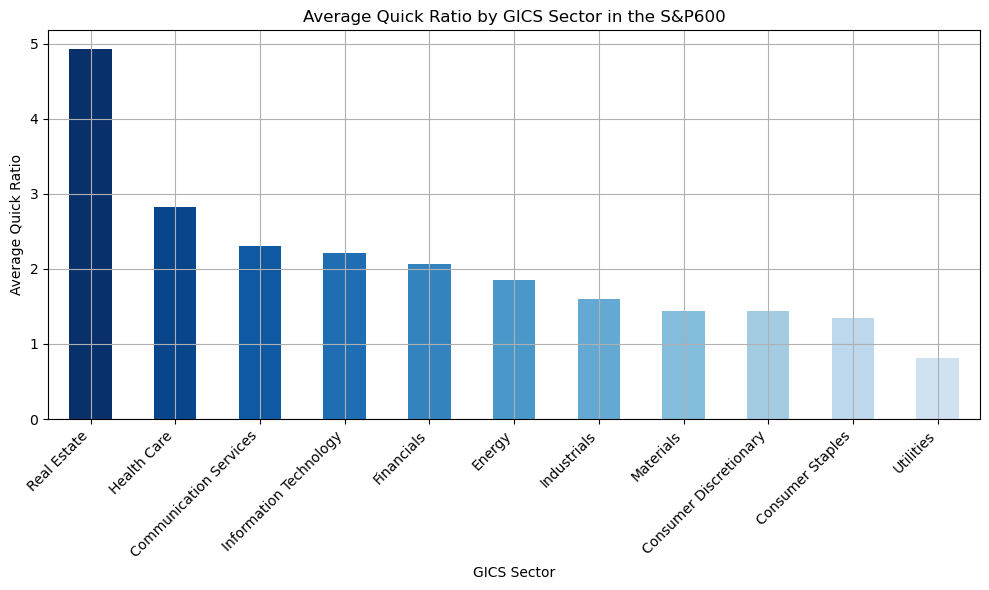

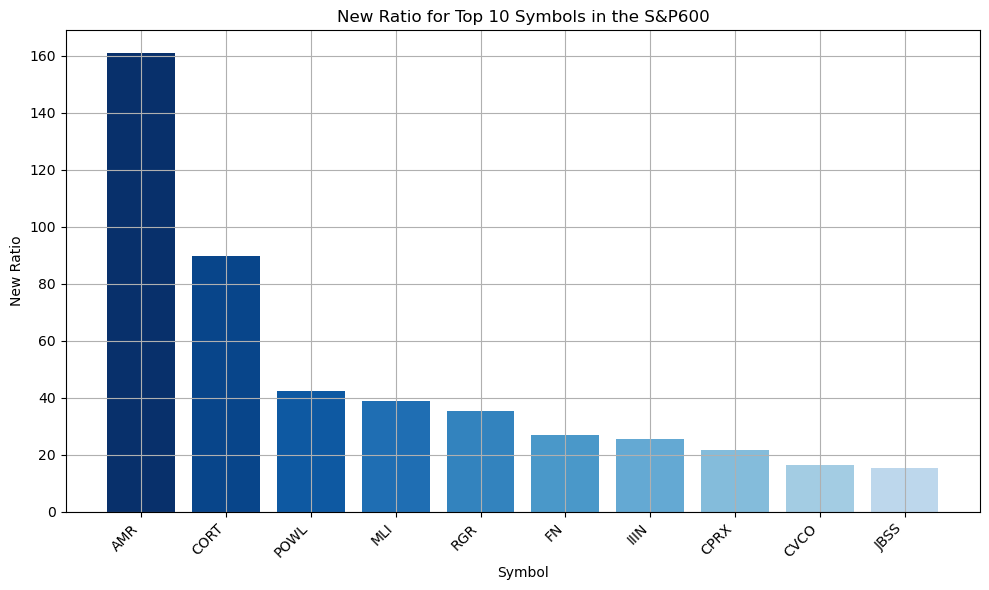

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define color palette for more variety
num_sectors = len(df['GICS Sector'].unique())
colors = plt.cm.Blues(np.linspace(1, 0.2, num_sectors))

# Plot Debt ratio graph
plt.figure(figsize=(10, 6))
sector_avg_debt_ratio = df.groupby('GICS Sector')["Debt Ratio"].mean().sort_values(ascending=True)
sector_avg_debt_ratio.plot(kind='bar', color=colors[:len(sector_avg_debt_ratio)])
plt.title("Average Debt Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Debt Ratio")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_debt_ratio.png')

# Plot liquidity ratio graph
plt.figure(figsize=(10, 6))
sector_avg_liquidity = df.groupby('GICS Sector')["Liquidity Ratio"].mean().sort_values(ascending=False)
sector_avg_liquidity.plot(kind='bar', color=colors[:len(sector_avg_liquidity)])
plt.title("Average Liquidity Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Debt Ratio")
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plot_liquidity_ratio.png')

# Plot profit margin graph


plt.figure(figsize=(10, 6))
sector_avg_profit = df.groupby('GICS Sector')["Calculated Profit Margin"].mean().sort_values(ascending=False)

# Extracting x and y values for scatter plot
x = range(len(sector_avg_profit))
y = sector_avg_profit.values

plt.scatter(x, y, color='blue')  # Scatter plot instead of line plot
plt.title("Average Profit Margin by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Profit Margin")
plt.xticks(x, sector_avg_profit.index, rotation=45, ha='right')  # Using sector names as x ticks
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_profit_margin.png')


plt.figure(figsize=(10, 6))
sector_avg_turnover = df.groupby('GICS Sector')["Asset Turnover Ratio"].mean().sort_values(ascending=False)

plt.stem(sector_avg_turnover, linefmt='b-', markerfmt='bo', basefmt='k-', use_line_collection=True)  # Using stem plot
plt.title("Average Asset Turnover Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Asset Turnover Ratio")

# Using actual GICS sector column names as x-axis labels
plt.xticks(range(len(sector_avg_turnover)), sector_avg_turnover.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('plot_asset_turnover_ratio.png')

# Plot quick ratio graph
plt.figure(figsize=(10, 6))
sector_avg_quick = df.groupby('GICS Sector')["Quick Ratio"].mean().sort_values(ascending=False)
sector_avg_quick.plot(kind='bar', color=colors[:len(sector_avg_quick)])
plt.title("Average Quick Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Quick Ratio")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_quick_ratio.png')


sorted_df = df.sort_values(by='New Ratio', ascending=False)

# Create a new DataFrame with only the top 10 entries
top_10_df = sorted_df.head(10)

# Plot new ratio graph
plt.figure(figsize=(10, 6))
plt.bar(top_10_df['Symbol'], top_10_df['New Ratio'], color=colors[:len(sector_avg_quick)])  # Using bar plot
plt.title("New Ratio for Top 10 Symbols in the S&P600")
plt.xlabel('Symbol')
plt.ylabel("New Ratio")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_new_ratio.png')

plt.show()  # Optional to display the plot
